In [1]:
import numpy as np
from scipy.stats import norm
from scipy import stats

from utils import get_filenames, despine_ax
from stan import *
from loaders import StabilityDurationRecording

plt.style.use('jns')

In [2]:
LW_BAR = 1.5

In [3]:
txt_files_spodo = get_filenames('data/tungsten recordings/spodoptera', contains='txt')

In [4]:
def get_data(dur, bw=0.05):
    spiketrains = []
    kdes = []
    ends = []

    for file in txt_files_spodo:
        rec = StabilityDurationRecording(file)

        n = 1
        for i in range(n):
            resp = rec[dur][i]
            kdes.append(resp.kde(kde_xx, shift=True, bw=bw))
            spiketrains.append(resp.spiketrain - resp.stim_end)
            ends.append(find_end(resp.spiketrain - resp.stim_start, dur=dur))
            
    return kdes, spiketrains, ends

In [5]:
def get_data_obj(dur, bw=0.05):
    responses = []

    for file in txt_files_spodo:
        rec = StabilityDurationRecording(file)

        n = 1
        for i in range(n):
            resp = rec[dur][i]
            responses.append(resp)
            
    return responses

In [6]:
def get_kde(tarr, spiketrain, bw=0.05):
    if not callable(bw):
        scales = bw
    else:
        scales = bw(spiketrain)[:,None]
    return norm.pdf(tarr, loc=spiketrain[:,None], scale=scales).sum(axis=0)

In [7]:
def test_res_2_text(res):
    pval = res.pvalue
    
    if pval < 1e-3:
        return '***'
    elif pval < 1e-2:
        return '**'
    elif pval < 5e-2:
        return '*'
    else:
        return ''

def rasters_from_responses(ax, responses, dur, xmin=-0.11, xmax=0.2, plot_ends=True, plot_stim=True, align='stim_end'):
    end = np.nanmedian(apply_func(responses, find_end, dur))

    if align == 'stim_end':
        spiketrains = [x.spiketrain - x.stim_end for x in responses]
    elif align == 'resp_end':
        spiketrains = [x.spiketrain - (x.stim_start + end) for x in responses]
    
#     if dur == 2:
#         spiketrains = [x for x in spiketrains if ((x > 0) & (x < 0.5)).sum() < 10]
    
    ax.eventplot(spiketrains, color='black', lw=0.8);

    if plot_stim:
        ax.axvspan(-dur, 0, color='C0', alpha=0.3)

    ax.set_xlim(xmin, xmax)

    if plot_ends:
        ax.axvline(end - dur, color='red')
    
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.spines['left'].set_visible(False)
    
def inh_reb_counts(responses, dur):
    dur_str = str(int(dur*1000)) + 'ms'

    end = np.nanmedian(apply_func(responses, find_end, dur))
    print(end)

    spiketrains = [x.spiketrain - (x.stim_start + end) for x in responses]
    spiketrains_y = [x.spiketrain - x.stim_start for x in responses]


    inh_counts = np.array([((x > 0.1) & (x < 0.4)).sum() for x, y in zip(spiketrains, spiketrains_y) if eligible(y, dur)])
    reb_counts = np.array([((x > 1) & (x < 3)).sum() for x, y  in zip(spiketrains, spiketrains_y) if eligible(y, dur)])
    
    return inh_counts, reb_counts

def plot_inh_reb(axes, experiment, keys, durs, sig_positions, legend):
    inh_counts, reb_counts = inh_reb_counts(experiment, keys, durs)
    
    significance_levels = [test_res_2_text(stats.wilcoxon(i/0.3, r/2)) for i, r in zip(inh_counts, reb_counts)]
    
    inh_counts_mean = pd.Series(inh_counts).map(np.mean)
    reb_counts_mean = pd.Series(reb_counts).map(np.mean)
    
    params = {'ms': 4, 'marker': 'o'}
    
    axes[0].plot(inh_counts_mean / 0.4, label='inh', c='C3', **params)
    axes[0].plot(reb_counts_mean / 2, label='reb', c='C2', **params)
    diff = (reb_counts_mean / 2) - (inh_counts_mean / 0.4)
    axes[1].plot(diff, label='reb-inh', c='C0', **params)
    
    axes[1].axhline(0, color='black', linestyle='dashed')
    
    for i in range(len(diff)):
        diffs = np.array(reb_counts[i])/2 - np.array(inh_counts[i])/0.4
        print(diffs.min(), diffs.max())
        axes[1].scatter(i+np.random.randn(len(diffs))*0.1, diffs, color='black', marker='x', s=8, linewidth=0.8, alpha=0.5)
    
    if legend:
        axes[0].legend(frameon=False)
        axes[1].legend(frameon=False)
    
    for i, (sig, sig_pos) in enumerate(zip(significance_levels, sig_positions)):
        # axes[1].text(i, sig_pos, sig, ha='center', fontsize=6)
        print(i, sig)
    

def plot_inh_reb_dur(axes, sig_positions=None):
    if sig_positions is None:
        sig_positions = [0] * len(durations_long)
    
    dur_strings = [str(int(x*1000))+'ms' for x in durations_long]
    plot_inh_reb(axes, due, dur_strings, durations_long, sig_positions, legend=True)

    for ax in axes[:1]:
        ax.set_xticklabels([])
#     axes[2].tick_params(axis='x', labelrotation = 45)
    axes[1].set_xticks(range(11))

def plot_inh_reb_dose(axes, dur, sig_positions=None):
    if sig_positions is None:
        sig_positions = [0] * 3
    
    dur_str = str(int(dur*1000))+'ms'
    dur_strings = [dur_str] * 3
    keys = [(dose, dur_str) for dose in doses]
    plot_inh_reb(axes, dudoe, keys, [dur]*3, sig_positions, legend=False)

    for ax in axes[:2]:
        ax.set_xticklabels([])


def plot_inh_reb_durdose(axes, dose, sig_positions=None):
    if sig_positions is None:
        sig_positions = [0] * 3
    
    durations = ['20ms','200ms','2000ms']
    keys = [(dose, dur_str) for dur_str in durations]
    plot_inh_reb(axes, dudoe, keys, [0.02, 0.2, 2], sig_positions, legend=False)
    

def plot_rasters(axes, *args, **kwargs):
    for dur, ax in zip(durations_long, axes):
        dur_str = str(int(dur*1000)) + 'ms'
        rasters_from_responses(ax, due[dur_str], dur, *args, **kwargs)
    
    for ax in axes[:-1]:
        ax.set_xticklabels([])
    

def plot_dudoe_dur(axes, dur, *args, **kwargs):
    for ax, dose in zip(axes, doses):
        dur_str = str(int(dur*1000)) + 'ms'
        rasters_from_responses(ax, dudoe[dose, dur_str], dur, *args, **kwargs)
    
    for ax in axes[:-1]:
        ax.set_xticklabels([])

In [8]:
file = txt_files_spodo[0]
responses = [StabilityDurationRecording(file) for file in files]

NameError: name 'files' is not defined

In [9]:
for dur in [0.02, 0.2, 2]:
    responses = get_data_obj(dur)
    inh, reb = inh_reb_counts(responses, dur)
    print(stats.wilcoxon(inh/0.3, reb/2))

    resp_end = np.nanmedian([find_end(r.spiketrain - r.stim_start, dur=dur) for r in responses])
    print(resp_end)

0.18369999999998754
WilcoxonResult(statistic=24.0, pvalue=0.146484375)
0.18369999999998754
0.2472000000000083
WilcoxonResult(statistic=3.0, pvalue=0.00244140625)
0.2472000000000083
1.9948500000000031
WilcoxonResult(statistic=0.0, pvalue=0.00048828125)
1.9948500000000031


In [11]:
mean_inhs = []
mean_rebs = []
diffs = []

for dur in [0.02, 0.2, 2]:
    responses = get_data_obj(dur)
    inh, reb = inh_reb_counts(responses, dur)
    
    mean_inhs.append(np.mean(inh)/0.4)
    mean_rebs.append(np.mean(reb)/2)
    diffs.append(reb-inh)
    
    # for response in responses
    # eligible()
    # resp_end = np.nanmedian([find_end(r.spiketrain - r.stim_start, dur=dur) for r in responses if ])
    # print(resp_end)

0.18369999999998754
0.2472000000000083
1.9948500000000031


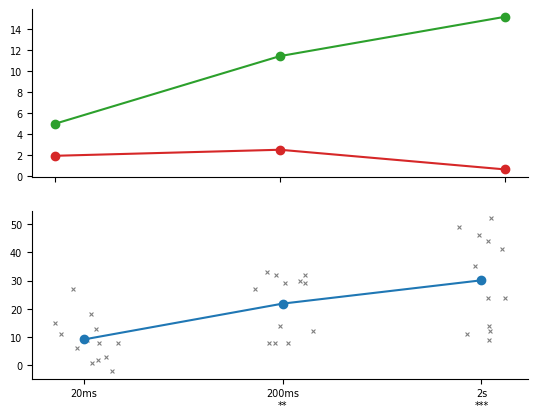

In [12]:
fig, axes = plt.subplots(nrows=2, gridspec_kw={'height_ratios': [1, 1]})

def plot_diffs(axes):
    axes[0].plot(mean_inhs, marker='o', color='C3', label='inh')
    axes[0].plot(mean_rebs, marker='o', color='C2', label='reb')
    
    axes[1].plot([x.mean() for x in diffs], marker='o')

    for i, darr in enumerate(diffs):
        axes[1].scatter(np.random.randn(len(darr))*0.1+i, darr, color='black', marker='x', s=8, linewidth=0.8, alpha=0.5)

    axes[0].set_xticks([0, 1, 2])
    axes[0].set_xticklabels([])
    axes[1].set_xticks([0, 1, 2])
    axes[1].set_xticklabels(['20ms','200ms\n**','2s\n***'])
    
plot_diffs(axes)

(array([0.85, 1.15]), array([0.1637, 0.1637]))
(array([1.85, 2.15]), array([0.0472, 0.0472]))
(array([2.85, 3.15]), array([-0.00515, -0.00515]))


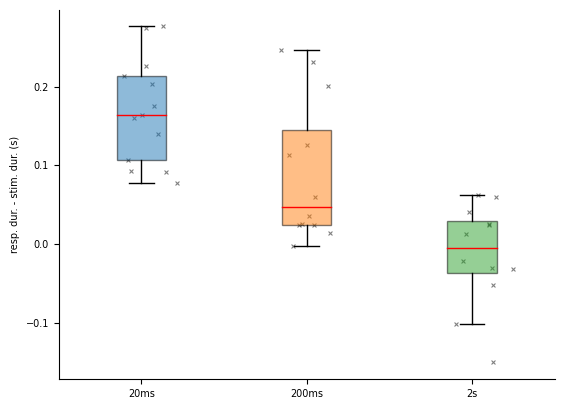

In [13]:
durations = [0.02, 0.2, 2]

def plot_dur_ends(ax):
    ends = []

    for dur in durations:
        dur_str = str(int(dur*1000)) + 'ms'
        responses = get_data_obj(dur)
        ends_full = apply_func(responses, find_end, dur) - dur
        ends.append(ends_full[ends_full == ends_full])

    # bplot = ax.boxplot(ends, patch_artist=True, medianprops={'color': 'red'}, flierprops={'ms': 4})
    bplot = ax.boxplot(ends, patch_artist=True, medianprops={'color': 'red'}, flierprops={'ms': 0})
    
    for i, end_list in enumerate(ends):
        ax.scatter(i+1 + np.random.randn(len(end_list))*0.1, end_list, color='black', marker='x', s=8, linewidth=0.8, alpha=0.5)
    
    for med in bplot['medians']:
        print(med.get_data())
    
    for seg in ['boxes']:
        for i, patch in enumerate(bplot[seg]):
#             patch.set_edgecolor(f'C{i}')
#             patch.set_lw(2)
            patch.set_facecolor(f'C{i}')
            patch.set_alpha(0.5)
    
    ax.set_ylabel('resp. dur. - stim. dur. (s)')
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['20ms','200ms','2s'])

        
fig, ax = plt.subplots()
plot_dur_ends(ax)

In [14]:
stats.wilcoxon(inh/0.4, reb/2)

WilcoxonResult(statistic=0.0, pvalue=0.00048828125)

In [15]:
dur = 2
responses = get_data_obj(dur)
inh, reb = inh_reb_counts(responses, dur)

1.9948500000000031


0.18369999999998754
0.2472000000000083
1.9948500000000031


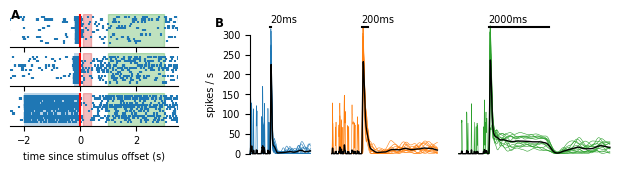

In [145]:
kde_xx = np.linspace(-1, 5, 1000)

fig = plt.figure(figsize=(6, 1.4))

gs_rasters = fig.add_gridspec(3,1, top=1, bottom=0.2, left=0, right=0.28)

axes = [fig.add_subplot(gs_rasters[i]) for i in range(3)]

for i, (ax, dur) in enumerate(zip(axes, [0.02, 0.2, 2])):
    _, spiketrains, ends = get_data(dur)

    med_end = np.nanmedian(ends)
    print(med_end)
    
    ax.eventplot([x - med_end + dur for x in spiketrains])
    ax.set_xlim(-2.5, 3.5)
    ax.axvspan(-dur, 0, alpha=0.3)
    
    
    ax.axvspan(0.1, 0.4, alpha=0.3, color='C3')
    ax.axvspan(1, 3, alpha=0.3, color='C2')
    
    
    ax.axvline(0, color='red')
    despine_ax(ax, where='l')
    
    if i != 2:
        ax.set_xticklabels([])

ax.set_xlabel('time since stimulus offset (s)')
axes[0].set_title('A', fontweight='bold', x=0.03, y=0.6)

gs_kdes = fig.add_gridspec(1,3, top=0.85, bottom=0., left=0.4, right=1, width_ratios=[0.4, 0.7, 1])

axes = [fig.add_subplot(gs_kdes[i]) for i in range(3)]

for i, (ax, dur, xmax, l) in enumerate(zip(axes, [0.02, 0.2, 2], [2, 2.5, 4], ['B','C','D'])):
    _, spiketrains, __ = get_data(dur)
    kdes = []
    mask = (kde_xx > -1) & (kde_xx < xmax)
    for st in spiketrains:
        kde = get_kde(kde_xx, st+dur, bw_func)
        kdes.append(kde)
        ax.plot(kde_xx[mask], kde[mask], c=f'C{i}', lw=0.4, clip_on=False)
    
    ax.plot(kde_xx[mask], np.mean(kdes, axis=0)[mask], c='black', lw=1, clip_on=False)
        
    ax.set_ylim(0, 300)
    ax.set_xlim(-1, xmax)
    
    ax.plot([0,0+dur],[320,320], lw=LW_BAR, color='black', clip_on=False)
    ax.text(-0.02, 330, f'{dur*1000:.0f}ms', ha='left')
    
    despine_ax(ax, where='b')
    
    if i == 0:
        ax.set_title(l, fontweight='bold', x=-0.5, y=1.0)
    
    if i > 0:
        despine_ax(ax, 'l')
        
axes[0].set_ylabel('spikes / s')

plt.savefig('img/spodo_full.png')

(array([0.85, 1.15]), array([0.1637, 0.1637]))
(array([1.85, 2.15]), array([0.0472, 0.0472]))
(array([2.85, 3.15]), array([-0.00515, -0.00515]))


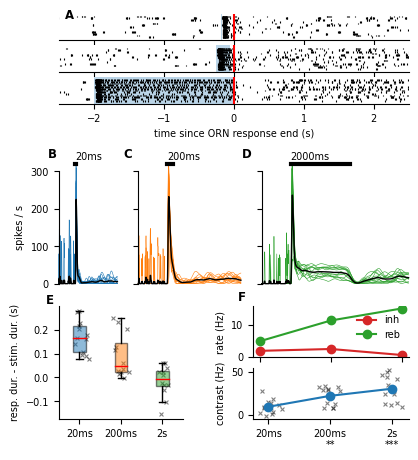

In [154]:
kde_xx = np.linspace(-1, 5, 1000)

fig = plt.figure(figsize=(3.5, 4.5))

gs_rasters = fig.add_gridspec(3,1, top=0.9, bottom=0.7, left=0, right=1)

axes = [fig.add_subplot(gs_rasters[i]) for i in range(3)]

for i, (ax, dur) in enumerate(zip(axes, [0.02, 0.2, 2])):
    _, spiketrains, ends = get_data(dur)

    med_end = np.nanmedian(ends)
    
    ax.eventplot([x+dur-med_end for x in spiketrains], color='black', lw=0.8)
    ax.set_xlim(-2.5, 2.5)
    ax.axvspan(-dur - (med_end-dur), -(med_end-dur), alpha=0.3)
    ax.axvline(0, color='red')
    despine_ax(ax, where='l')
    
    if i != 2:
        ax.set_xticklabels([])

ax.set_xlabel('time since ORN response end (s)')
axes[0].set_title('A', fontweight='bold', x=0.03, y=0.5)

gs_kdes = fig.add_gridspec(1,3, top=0.55, bottom=0.3, left=0., right=1, width_ratios=[0.4, 0.7, 1])

axes = [fig.add_subplot(gs_kdes[i]) for i in range(3)]

for i, (ax, dur, xmax, l) in enumerate(zip(axes, [0.02, 0.2, 2], [2.5, 2.5, 4], ['B','C','D'])):
    _, spiketrains, __ = get_data(dur)
    kdes = []
    mask = (kde_xx > -1) & (kde_xx < xmax)
    for st in spiketrains:
        kde = get_kde(kde_xx, st+dur, bw_func)
        kdes.append(kde)
        ax.plot(kde_xx[mask], kde[mask], c=f'C{i}', lw=0.4, clip_on=False)
    
    ax.plot(kde_xx[mask], np.mean(kdes, axis=0)[mask], c=f'black', lw=1, clip_on=False)
        
    ax.set_ylim(0, 300)
    ax.set_xlim(-1, xmax)
    
    ax.plot([0,0+dur],[320,320], lw=3, color='black', clip_on=False)
    ax.text(-0.02, 330, f'{dur*1000:.0f}ms', ha='left')
    
    despine_ax(ax, where='b')
    ax.set_title(l, fontweight='bold', x=-0.1, y=1.05)
    
    if i != 0:
        ax.set_yticklabels([])
    else:
        ax.set_ylabel('spikes / s')
        

gs_triphas = fig.add_gridspec(2,2, top=0.25, bottom=0.0, left=0., right=1, height_ratios=[1, 1], width_ratios=[0.8,1], wspace=0.5)
axes = [fig.add_subplot(gs_triphas[i,1]) for i in range(2)]
axes[0].set_title('F', loc='left', fontweight='bold', x=-0.1, y=0.95)

axes[0].set_ylabel('rate (Hz)')
axes[1].set_ylabel('contrast (Hz)')


plot_diffs(axes)
axes[0].legend(frameon=False)

ax = fig.add_subplot(gs_triphas[:,0])
plot_dur_ends(ax)
ax.set_title('E', loc='left', fontweight='bold', x=-0.1, y=0.95)

plt.savefig('img/spodo_full.png')